In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("PVEVDATA.csv")
df.columns = [col.strip().replace(" ", "_") for col in df.columns]

# Compute solar energy consumption
df["Solar_Consumption_By_Battery_kWh"] = df["Solar_Power_kW"] * df["Charging_Duration_Min"] / 60
df = df.dropna()
df = df[df["Solar_Consumption_By_Battery_kWh"] > 0]

features = [
    "Solar_Power_kW", "Solar_Irradiance_Wm2", "Battery_SOC_%",
    "Charging_Power_kW", "Charging_Duration_Min",
    "Initial_Battery_SOC_%", "Final_Battery_SOC_%"
]

X = df[features].values
y = df["Solar_Consumption_By_Battery_kWh"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for LSTM: [samples, time_steps, features]
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [3]:
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(32, activation='tanh'),
    Dropout(0.3),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - loss: 1214.3973 - root_mean_squared_error: 34.8174 - val_loss: 1061.5795 - val_root_mean_squared_error: 32.5819
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1235.4042 - root_mean_squared_error: 35.1279 - val_loss: 1051.8055 - val_root_mean_squared_error: 32.4316
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1242.0845 - root_mean_squared_error: 35.2129 - val_loss: 1030.8082 - val_root_mean_squared_error: 32.1062
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1125.8960 - root_mean_squared_error: 33.5448 - val_loss: 986.4196 - val_root_mean_squared_error: 31.4073
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1169.0583 - root_mean_squared_error: 34.1752 - val_loss: 914.2059 - val_root_mean_squared_error: 30.2358
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 983.2947 - root_mean_squared_error: 31.3387 - val_loss: 832.4420 - val_root_mean_squared_error: 28.8521
Epoch 7/200


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step
🔢 R² Score: 0.9744
📉 MSE: 10.97


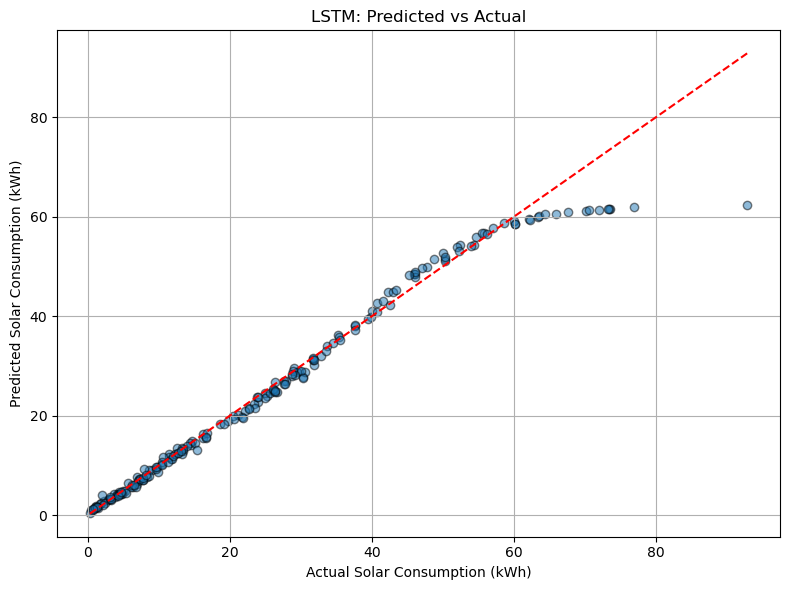

In [55]:
y_pred = model.predict(X_test).flatten()

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"🔢 R² Score: {r2:.4f}")
print(f"📉 MSE: {mse:.2f}")

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Solar Consumption (kWh)")
plt.ylabel("Predicted Solar Consumption (kWh)")
plt.title("LSTM: Predicted vs Actual")
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig("lstmpred.png", dpi=300)